In [55]:
from PIL import Image
import numpy as np
import math
from scipy import signal
import cv2
import torch
import pdb
from scipy.optimize.zeros import results_c

In [56]:
# takes the given array and converts all numbers to type float, and then 
# divides it by 255
def normalize_array(array):
  map_array = map(lambda x: float(x)/255, array)
  arr = list(map_array)
  return np.array(arr)

# takes an integer and makes sure it is within range 0-255
def clamp(n): 
  return max(0, min(n, 255))


In [57]:
# Part 2

# 1.
# creates a box filter with dimensions n x n
def boxFilter(n):
  # checking to make sure it is odd
  assert n%2 == 1, "Dimension must be odd"

  matrix = []
  n2 = n * n

  # creating the matrix
  matrix = [[1/n2]*n for i in range(n)]
  np_matrix = np.array(matrix)
  return np_matrix

In [58]:
bf = boxFilter(3)
bf1 = 3*bf
print(bf1)

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


In [59]:
print("Example 1:")
print(boxFilter(3))
print("Example 2:")
print(boxFilter(5))

Example 1:
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
Example 2:
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


In [60]:
boxFilter(4)

AssertionError: ignored

In [61]:
# 2.
# Creates a gaussian filter of one dimension, of size 6*sigma rounded up to the
# nearest odd number, for a given positive sigma
def gauss1d(sigma):

  # calculating how long the array should be, and rounding it up by one
  # if it is an even number
  length = math.ceil(6 * sigma)
  if length%2 != 1:
    length += 1

  # creating the array of size length, and mapping the gaussian function onto
  # the list
  edge = math.floor(length/2)
  start = -edge
  init_list = list(range(start, edge+1))
  coeffVal = 1/(2*math.pi*sigma**2)  
  map_filter = map(lambda x: (math.exp(-x**2/(2*sigma**2))),
                   init_list)
  
  
  # converting the mapped object back to a list, dividing it by the overall sum
  # then returning it
  filter = np.array(list(map_filter))
  final_filter = filter/np.sum(filter)  
  return final_filter

In [62]:
print("Example 1:")
print(gauss1d(0.3))
print("Example 2:")
print(gauss1d(0.5))
print("Example 3:")
print(gauss1d(1))
print("Example 4:")
print(gauss1d(2))

Example 1:
[0.00383626 0.99232748 0.00383626]
Example 2:
[0.10650698 0.78698604 0.10650698]
Example 3:
[0.00443305 0.05400558 0.24203623 0.39905028 0.24203623 0.05400558
 0.00443305]
Example 4:
[0.0022182  0.00877313 0.02702316 0.06482519 0.12110939 0.17621312
 0.19967563 0.17621312 0.12110939 0.06482519 0.02702316 0.00877313
 0.0022182 ]


In [63]:
# 3.
# creates a 2d gaussian filter of of size 6*sigma rounded up to the
# nearest odd number, for a given positive sigma
def gauss2d(sigma):
   
  # load 1 dimension array
  oneDim = gauss1d(sigma)  

  """
  # square root all the numbers in the list
  sqrt_map = map(lambda x: math.sqrt(x), oneDim)
  sqrt_matrix = list(sqrt_map)
  np_sqrt_matrix = np.array(sqrt_matrix)
  """
  # turn the arrays into two dimensions, and tranpose it
  twoDim = oneDim[np.newaxis]
  twoDimT = twoDim.T

  # perform a convolution on the square rooted 2d array with its  
  # transposed counterpart to get the 2d filter
  twoDimFilter = signal.convolve2d(twoDim, twoDimT, "full")

  return twoDimFilter

In [64]:
print("Example 1:")
print(gauss2d(0.5))
print("Example 2:")
print(gauss2d(1))

Example 1:
[[0.01134374 0.08381951 0.01134374]
 [0.08381951 0.61934703 0.08381951]
 [0.01134374 0.08381951 0.01134374]]
Example 2:
[[1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [1.76900911e-03 2.15509428e-02 9.65846250e-02 1.59241126e-01
  9.65846250e-02 2.15509428e-02 1.76900911e-03]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]]


In [65]:
# 4. a)
# param array: a picture np array of any size
# param filter: a np array of a filter to be applied to array
# takes the picture array and performs a convolution with the filter array
def convolve2d_manual(array, filter):

  # determine the how far the filter will have to go from center point
  filter_row_size = len(filter[0])
  len_from_center = math.floor(filter_row_size/2)

  arr_size_height = array.shape[0]
  arr_size_width = array.shape[1]
  fil_size_height = filter.shape[0]
  fil_size_width = filter.shape[1]

  # initialize 2d array full of zeroes of same shape as array
  result = [[0 for i in range(arr_size_width)] for j in range(arr_size_height)]

  # loop through every pixel of the array
  for h in range(arr_size_height):
    for w in range(arr_size_width):
      idx_w = -len_from_center
      idx_h = -len_from_center
      new_val = 0

      # check whether the filter will stay in bounds, if yes then apply it 
      # and add to the result array otherwise add nothing and move 
      # to next pixel
      for h1 in range((fil_size_height-1), -1, -1):
        for w1 in range((fil_size_width-1), -1, -1):
          if (h + idx_h) >= arr_size_height or (w + idx_w) >= arr_size_width:
            new_val += 0
            idx_w += 1
          elif (h + idx_h) < 0 or (w + idx_w) < 0:
            new_val += 0
            idx_w += 1
          else:
            new_val += (filter[h1][w1] * array[h + idx_h][w + idx_w])
            idx_w += 1
        idx_w = -len_from_center
        idx_h += 1

      # add value to the result array
      result[h][w] = new_val        
  np_result = np.array(result)
  return np_result

In [66]:
# 4. b)
# takes the array and performs a gaussian convolution for given sigma,
# using my implementation of convolve2d
def gaussconvolve2d_manual(array,sigma):
  gauss_filter = gauss2d(sigma)
  new_image = convolve2d_manual(array, gauss_filter)
  return new_image

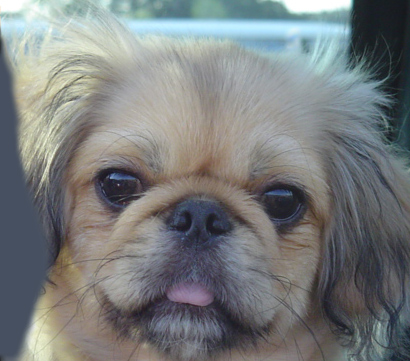

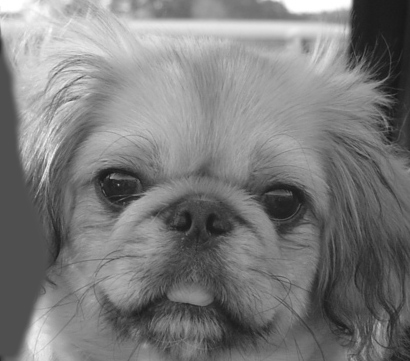

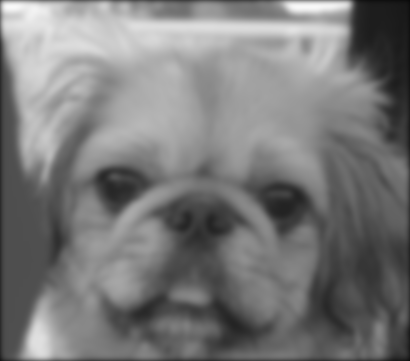

In [67]:

# 4. c)
dog_image = Image.open('/content/dog.jpg')
display(dog_image)
grey_image = dog_image.convert('L')
display(grey_image)
grey_image_arr = np.asarray(grey_image, dtype = 'float64')
conv_image_arr = gaussconvolve2d_manual(grey_image_arr, 3)
conv_image = Image.fromarray(conv_image_arr.astype(np.uint8))
display(conv_image)


In [68]:
# 5. a)
# takes the array and performs a gaussian convolution for given sigma,
# using the built in convolve2d
def gaussconvolve2d_scipy(array,sigma):
  gauss_filter = gauss2d(sigma)
  new_image = signal.convolve2d(array, gauss_filter, 'same')
  return new_image  

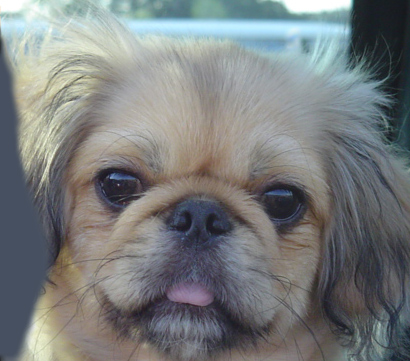

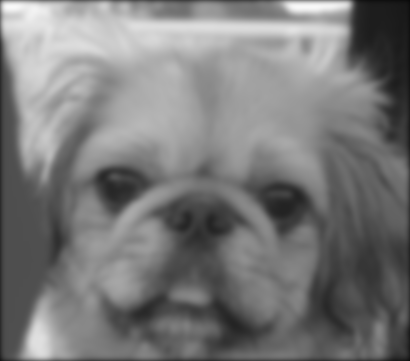

In [69]:
# 5. b), c)
display(dog_image)
conv_arr = gaussconvolve2d_scipy(grey_image_arr, 3)
conv = Image.fromarray(conv_arr.astype(np.uint8))
display(conv)

In [70]:
# 6.

import time
t1 = time.time() # start timestamp
conv_image_arr = gaussconvolve2d_manual(grey_image_arr, 10)
duration = time.time() - t1 # duration in seconds
print("Time taken for my implementation:")
print(duration)

t1 = time.time() # start timestamp
conv_image_arr = gaussconvolve2d_scipy(grey_image_arr, 10)
duration1 = time.time() - t1 # duration in seconds
print("Time taken built-in implementation:")
print(duration1)


Time taken for my implementation:
534.4907696247101
Time taken built-in implementation:
1.5677757263183594


It is very clear that my implementation is far slower than the built in implementation. This is probably due mostly to the fact that I used too many for loops, and is an excellent example going forward why I should not. Also I could speed it up by using separability which will reduce the time as well.

7. This code could be implemented more efficiently if we broke the filter up into two 1d arrays separated by X and Y. For each point instead of applying n by n filter, you would only apply a size n sized filter twice which is far more efficient. You could then combine the results from each array by convolving them to get the same final answer. This would run in 2n*(number of pixels) rather than n^2(number of pixels) which is a much better improvement.

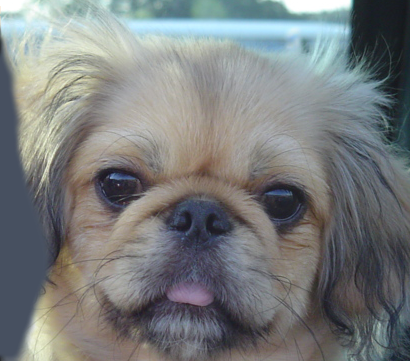

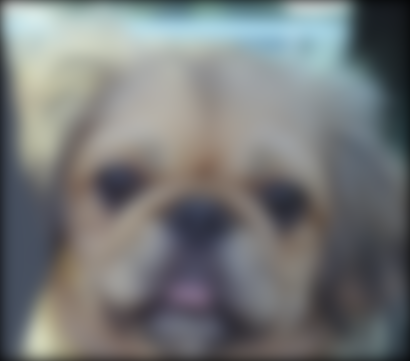

In [71]:
# Part 3:
# 1.

# open dog image and display it
dog_image = Image.open("/content/0b_dog.bmp")
display(dog_image)

# get each channel and convert them to floats
r_image = dog_image.getchannel("R")
r_arr = np.asarray(r_image, dtype = 'float64')
g_image = dog_image.getchannel("G")
g_arr = np.asarray(g_image, dtype = 'float64')
b_image = dog_image.getchannel("B")
b_arr = np.asarray(b_image, dtype = 'float64')

# perform a gaussian convolution on all three
r_gauss_arr = gaussconvolve2d_scipy(r_arr, 8)
g_gauss_arr = gaussconvolve2d_scipy(g_arr, 8)
b_gauss_arr = gaussconvolve2d_scipy(b_arr, 8)

# calculations are done so convert back to integers
r_int_arr = Image.fromarray(r_gauss_arr.astype(np.uint8))
g_int_arr = Image.fromarray(g_gauss_arr.astype(np.uint8))
b_int_arr = Image.fromarray(b_gauss_arr.astype(np.uint8))

# Now need to merge the three colour channel arrays back
low_pass_image = Image.merge("RGB", (r_int_arr, g_int_arr, b_int_arr))
display(low_pass_image)

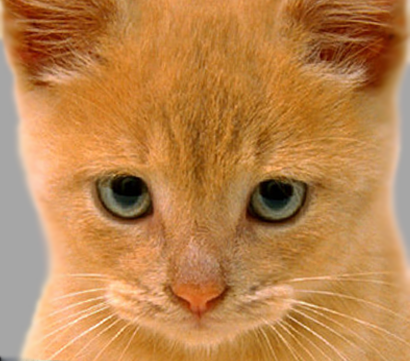

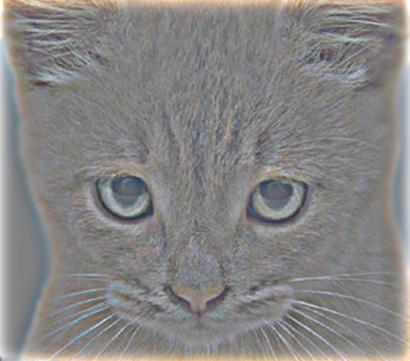

In [72]:
# 2.

# Open cat image and convert it to a rgb array
cat_image = Image.open("/content/0a_cat.bmp")
display(cat_image)

# get each channel and convert them to floats
r_image1 = cat_image.getchannel("R")
r_arr1 = np.asarray(r_image1, dtype = 'float64')
g_image1 = cat_image.getchannel("G")
g_arr1 = np.asarray(g_image1, dtype = 'float64')
b_image1 = cat_image.getchannel("B")
b_arr1 = np.asarray(b_image1, dtype = 'float64')

# perform a gaussian convolution on all three
r_gauss_arr1 = gaussconvolve2d_scipy(r_arr1, 8)
g_gauss_arr1 = gaussconvolve2d_scipy(g_arr1, 8)
b_gauss_arr1 = gaussconvolve2d_scipy(b_arr1, 8)

# subtract the original image by the gaussian arrays
high_pass_r = np.subtract(r_arr1, r_gauss_arr1)
high_pass_g = np.subtract(g_arr1, g_gauss_arr1)
high_pass_b = np.subtract(b_arr1, b_gauss_arr1)

# need to add 128 to the image
modified_high_pass_r = high_pass_r + 128
modified_high_pass_g = high_pass_g + 128
modified_high_pass_b = high_pass_b + 128

# clamp values between 0-255
final_r = np.minimum(255, np.maximum(modified_high_pass_r, 0))
final_g = np.minimum(255, np.maximum(modified_high_pass_g, 0))
final_b = np.minimum(255, np.maximum(modified_high_pass_b, 0))

# calculations are done so convert back to integers
r_int_arr1 = Image.fromarray(final_r.astype(np.uint8))
g_int_arr1 = Image.fromarray(final_g.astype(np.uint8))
b_int_arr1 = Image.fromarray(final_b.astype(np.uint8))

# merge three channels and display
high_pass_image = Image.merge("RGB", (r_int_arr1, g_int_arr1, b_int_arr1))
display(high_pass_image)

In [73]:
# 3. 

# combine two images to creates a hybrid image with the given sigma
def combine(p1, p2, sigma):
  # open pictures
  picture1 = Image.open(p1)
  picture2 = Image.open(p2)

  # get each channel and convert them to floats
  r_image1 = picture1.getchannel("R")
  r_arr1 = np.asarray(r_image1, dtype = 'float64')
  g_image1 = picture1.getchannel("G")
  g_arr1 = np.asarray(g_image1, dtype = 'float64')
  b_image1 = picture1.getchannel("B")
  b_arr1 = np.asarray(b_image1, dtype = 'float64')

  r_image2 = picture2.getchannel("R")
  r_arr2 = np.asarray(r_image2, dtype = 'float64')
  g_image2 = picture2.getchannel("G")
  g_arr2 = np.asarray(g_image2, dtype = 'float64')
  b_image2 = picture2.getchannel("B")
  b_arr2 = np.asarray(b_image2, dtype = 'float64')

  # perform gaussian convolution on each
  r_gauss_arr1 = gaussconvolve2d_scipy(r_arr1, sigma)
  g_gauss_arr1 = gaussconvolve2d_scipy(g_arr1, sigma)
  b_gauss_arr1 = gaussconvolve2d_scipy(b_arr1, sigma)

  r_gauss_arr2 = gaussconvolve2d_scipy(r_arr2, sigma)
  g_gauss_arr2 = gaussconvolve2d_scipy(g_arr2, sigma)
  b_gauss_arr2 = gaussconvolve2d_scipy(b_arr2, sigma)

  # for high pass image subtract from original picture
  high_pass_r = np.subtract(r_arr1, r_gauss_arr1)
  high_pass_g = np.subtract(g_arr1, g_gauss_arr1)
  high_pass_b = np.subtract(b_arr1, b_gauss_arr1)

  # add values together
  hybrid_r = np.add(r_gauss_arr2, high_pass_r)
  hybrid_g = np.add(g_gauss_arr2, high_pass_g)
  hybrid_b = np.add(b_gauss_arr2, high_pass_b)

  # clamp it between 0-255
  final_r = np.minimum(255, np.maximum(hybrid_r, 0))
  final_g = np.minimum(255, np.maximum(hybrid_g, 0))
  final_b = np.minimum(255, np.maximum(hybrid_b, 0))

  # calculations are done so convert back to integers
  r_int_arr = Image.fromarray(final_r.astype(np.uint8))
  g_int_arr = Image.fromarray(final_g.astype(np.uint8))
  b_int_arr = Image.fromarray(final_b.astype(np.uint8))

  # merge and display
  hybrid_image = Image.merge("RGB", (r_int_arr, g_int_arr, b_int_arr))
  display(hybrid_image)

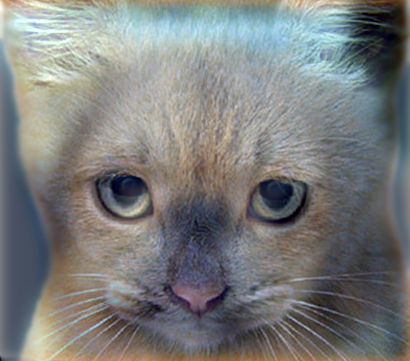

In [74]:
combine("/content/0a_cat.bmp", "/content/0b_dog.bmp", 8)

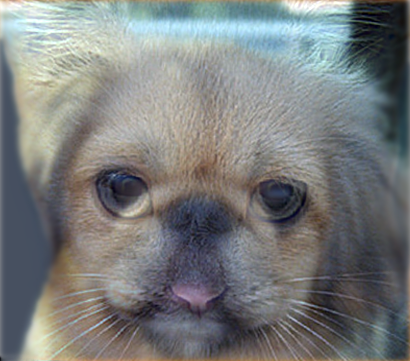

In [75]:
combine("/content/0a_cat.bmp", "/content/0b_dog.bmp", 3)

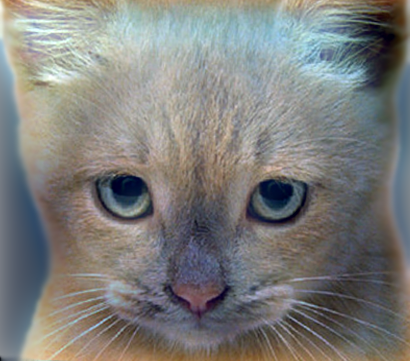

In [76]:
combine("/content/0a_cat.bmp", "/content/0b_dog.bmp", 15)

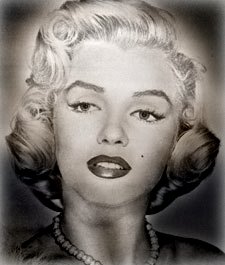

In [77]:
combine("/content/2b_marilyn.bmp", "/content/2a_einstein.bmp", 8)

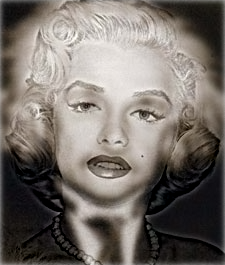

In [78]:
combine("/content/2b_marilyn.bmp", "/content/2a_einstein.bmp", 3)

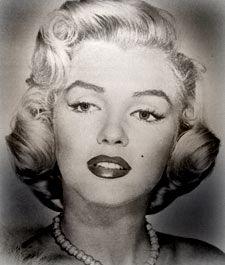

In [79]:
combine("/content/2b_marilyn.bmp", "/content/2a_einstein.bmp", 15)

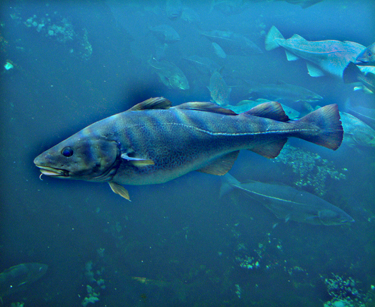

In [80]:
combine("/content/3a_fish.bmp", "/content/3b_submarine.bmp", 8)

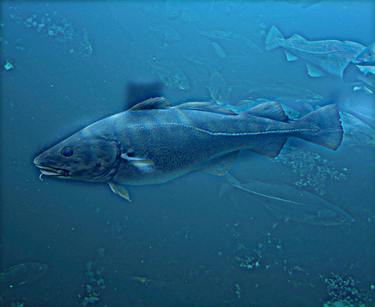

In [81]:
combine("/content/3a_fish.bmp", "/content/3b_submarine.bmp", 3)

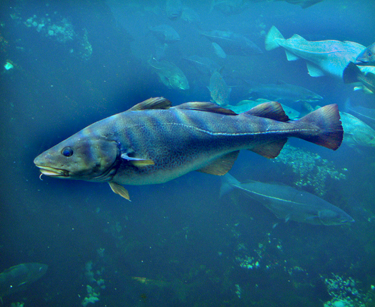

In [82]:
combine("/content/3a_fish.bmp", "/content/3b_submarine.bmp", 15)

In [83]:
# Part 4
# 1.

# takes file path name, and denoises the image
def denoise_image(fileName):
  # Opens file and displays it
  image = Image.open(fileName)  
  print("Original Image")
  display(image)

  # convert image to a array
  image_arr = np.asarray(image, dtype = 'float32')
  image_arr1 = np.asarray(image, dtype = 'uint8')

  # apply the gaussian blur to denoise then display
  print("Gaussian Blur")
  gaussian = cv2.GaussianBlur(image_arr, (9,9), cv2.BORDER_DEFAULT)
  gaussian_image = Image.fromarray(gaussian.astype(np.uint8))
  display(gaussian_image)

  # apply the median blur to image then display
  # Note: I used type nint8 to avoid crashing
  print("Median Blur")
  median = cv2.medianBlur(image_arr1, 9)
  median_image = Image.fromarray(median.astype(np.uint8))
  display(median_image)

  # apply the bilateral filter to image then display
  print("Bilateral Filter")
  bilateral = cv2.bilateralFilter(image_arr, 10, 120, 120, cv2.BORDER_DEFAULT)
  bilateral_image = Image.fromarray(bilateral.astype(np.uint8))
  display(bilateral_image)

Original Image


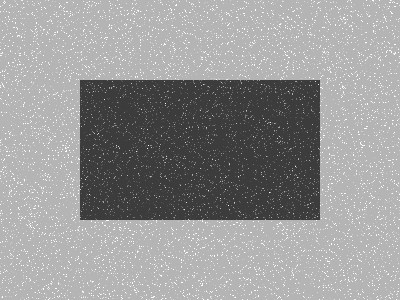

Gaussian Blur


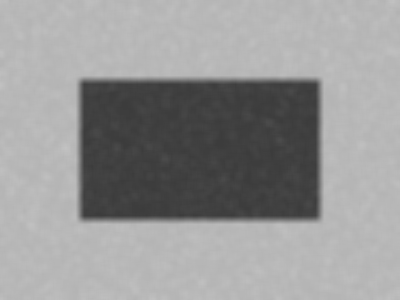

Median Blur


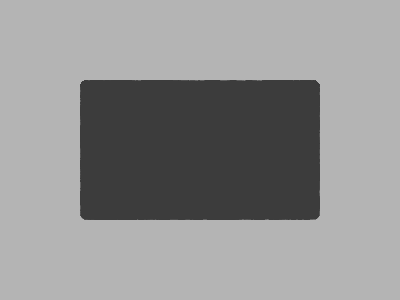

Bilateral Filter


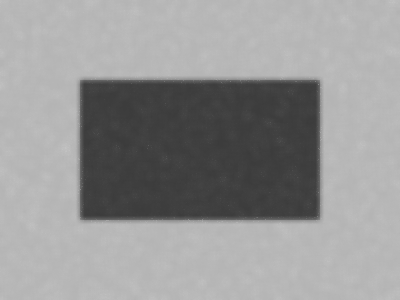

In [84]:
denoise_image("/content/box_gauss.png")

Original Image


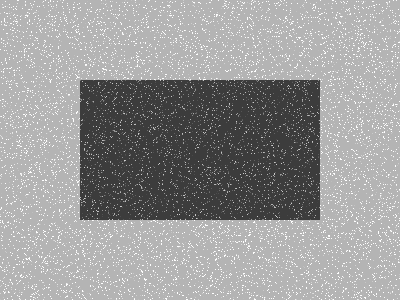

Gaussian Blur


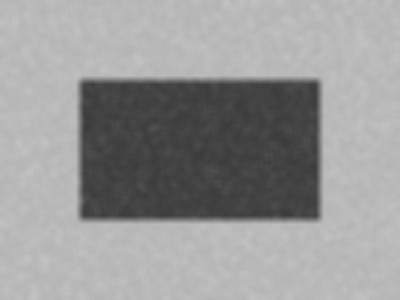

Median Blur


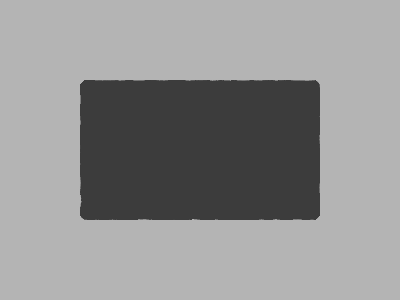

Bilateral Filter


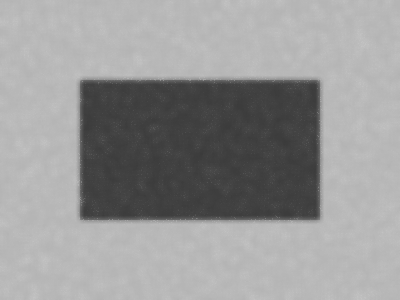

In [85]:
denoise_image("/content/box_speckle.png")

In [86]:
# 2.

# takes file path name, and denoises the image with the preset values
def denoise_image_set(fileName):
  # Opens file and displays it
  image = Image.open(fileName)  
  print("Original Image")
  display(image)

  # convert image to a array
  image_arr = np.asarray(image, dtype = 'float32')
  image_arr1 = np.asarray(image, dtype = 'uint8')

  # apply the gaussian blur to denoise then display
  print("Gaussian Blur")
  gaussian = cv2.GaussianBlur(image_arr, ksize=(7, 7), sigmaX=50)
  gaussian_image = Image.fromarray(gaussian.astype(np.uint8))
  display(gaussian_image)

  # apply the median blur to image then display
  print("Median Blur")
  median = cv2.medianBlur(image_arr1, 7)
  median_image = Image.fromarray(median.astype(np.uint8))
  display(median_image)

  # apply the bilateral filter to image then display
  print("Bilateral Filter")
  bilateral = cv2.bilateralFilter(image_arr, 7, sigmaColor=150, sigmaSpace=150)
  bilateral_image = Image.fromarray(bilateral.astype(np.uint8))
  display(bilateral_image)

Original Image


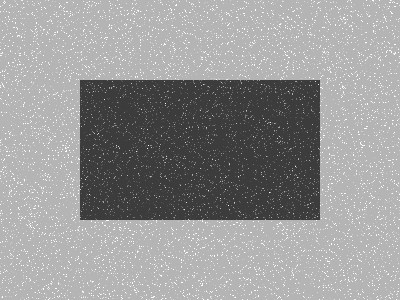

Gaussian Blur


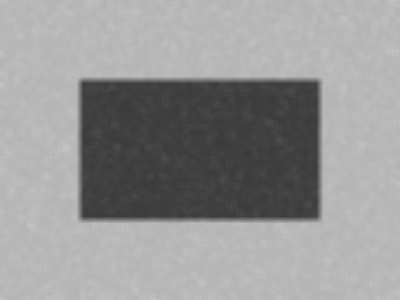

Median Blur


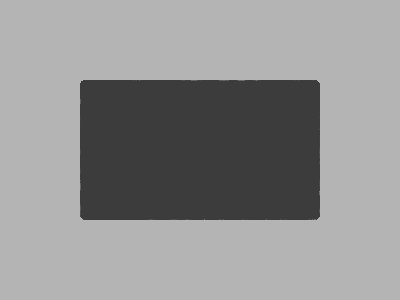

Bilateral Filter


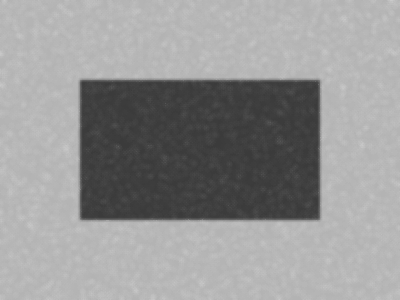

In [87]:
denoise_image_set("/content/box_gauss.png")

Original Image


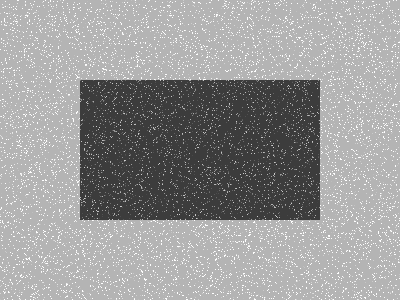

Gaussian Blur


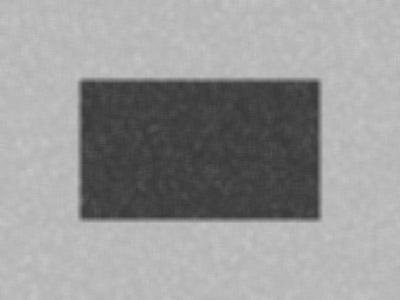

Median Blur


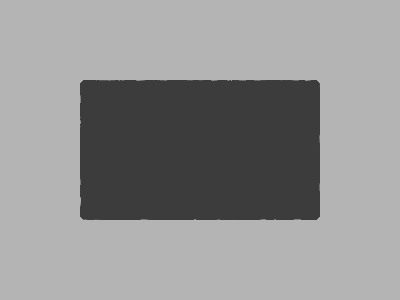

Bilateral Filter


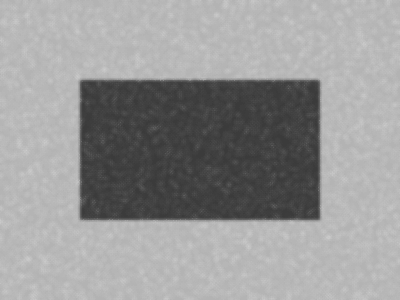

In [88]:
denoise_image_set("/content/box_speckle.png")

**2.**

Median filtering creates a nice smooth finish and seems to work very well on these images, but it struggles to keep the edges sharp in the image.

Bilateral is much better at edge preserving than median, but it requires more operations than the others which takes more time.

Gaussian blurring also preserves edges well and is faster than Bilateral, but it appears to perform slightly worse than bilateral.